In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

import math
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm.notebook import tqdm
from easydict import EasyDict
from IPython.display import HTML

device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def get_melkwargs(params):
    return {
        "n_fft": params.n_fft,
        "n_mels": params.n_mels,
        "hop_length": params.hop_length
    }

def conv(array):
    array = array.view(1, 1, -1)
    kernel = torch.ones(1, 1, 201)
    array = torch.nn.functional.conv1d(array, kernel)
    array = array.squeeze()
    return array

def show(params, signal, events=None, 
         events_start_time=None, events_end_time=None, 
         manual_events=None, directions=None, views=None,
         from_time=0, till_time=86400,
         save=False):
    
    print(f'{from_time // 60:02.0f}:{from_time % 60:02.0f} - {till_time // 60:02.0f}:{till_time % 60:02.0f}')
    
    signal = signal[from_time * params.sr: till_time * params.sr]
    
    signal_length = round(len(signal) / params.sr)

    nrows = 3
    width = (till_time - from_time) // 4
    height = 4 * nrows
    fig, axes = plt.subplots(nrows=nrows, figsize=(width, height))
    
    ax0, ax1, ax2 = axes
    
    for ax in axes:
        ax.margins(0, 0.02)
        
    x_axis = np.arange(from_time, from_time + signal_length)
    ax0.plot(x_axis, np.zeros(signal_length), marker='o', markersize=3, color='black')
    
    def formatter(x, y):
        return f'{x // 60:02.0f}:{x % 60:02.0f}'

    ax0.xaxis.set_major_formatter(tick.FuncFormatter(formatter))
    
    # show events from eyedea engine
    if events is not None:
        colors = 'violet'
        mask = (events >= from_time) & (events <= till_time)
        events = events[mask]
        
        # color code direction
        if directions is not None:
            colors = ['red' if direction == 'outgoing' else 'green' for direction in directions[mask]]
        
        # color code direction
        if views is not None:
            colors = ['red' if view == 'rear' else 'green' for view in views[mask]]

        ax0.vlines(events, 0, 1, color=colors, linewidth=2.0)
                 
    # show manual annotations
    if manual_events is not None:
        mask = (manual_events >= from_time) & (manual_events <= till_time)
        manual_events = manual_events[mask]
        ax0.vlines(manual_events, 0, 1, color='black', linestyle=':', linewidth=2.0)
        
    # show start and end time of events
    if events_start_time is not None and events_end_time is not None:
        colors = 'violet'
        
        # color code direction
        if directions is not None:
            colors = ['red' if direction == 'outgoing' else 'green' for direction in directions]
        
        # color code direction
        if views is not None:
            colors = ['red' if view == 'rear' else 'green' for view in views]
        
        for event_start_time, event_end_time, color in zip(events_start_time, events_end_time, colors):
            if from_time <= event_start_time <= till_time and from_time <= event_end_time <= till_time:
                ax0.fill_between([event_start_time, event_end_time], [0], [1], color=color, alpha=0.25);                
    
    # plot signal amplitude
    each = 16
    ax1.plot(signal[::each], alpha=0.5)
    
    features = torch.stft(signal, n_fft=params.n_fft, hop_length=params.hop_length)
    energy = features[..., 0].pow(2)
    energy = energy.sum(0)
    energy = conv(energy)
    energy -= energy.min()
    energy /= energy.max()

    # plot signal energy
    x_axis = np.linspace(0, len(signal[::each]), len(energy))
    ax1_1 = ax1.twinx()
    ax1_1.plot(x_axis, energy, c='black')

    # plot spectrogram
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=params.sr, **get_melkwargs(params))
    features = transform(signal).numpy()
    features = librosa.power_to_db(features, ref=np.max)
    ax2.pcolormesh(features)
    
    # plot approximate position of highest energy
#     if events_start_time is not None and events_end_time is not None and views is not None:
#         lines = []
#         for event_start_time, event_end_time, view in zip(events_start_time, events_end_time, views):

#             # rear
#             event_start_time = event_start_time - 2.9
#             # front
#             event_end_time = event_end_time + 1.4

#             if from_time <= event_start_time <= till_time and from_time <= event_end_time <= till_time:
#                 if view == 'rear':
#                     lines.append(event_start_time)
#                 else:
#                     lines.append(event_end_time)

#         ax0.vlines(lines, 0, 1, color='magenta', linestyle=':', linewidth=2.0)
    
    if save:
        plt.savefig('vis.png', dpi=300)
        
    plt.show()

params = EasyDict()
params.n_fft = 1024
params.n_mels = 64
params.hop_length = 128
params.sr = 44100

# params.nn_hop_length = 1
# params.frame_length = 1

In [4]:
file = '20190819-Kutna Hora-L4-out-MVI_0040'

signal = load_audio(f'data/audio/{file}.MP4.wav')
signal_length = int(len(signal) / 44100)

csv = load_csv(f'{file}.MP4')
events = load_events_from_csv(csv)
directions = load_directions_from_csv(csv)
views = load_views_from_csv(csv)

try:
    manual_events = load_events(f'data/labels/{file}.MP4.txt')
except:
    manual_events = None

events_start_time, events_end_time = load_event_time_from_csv(csv)

00:00 - 01:00


/home/yermaand/miniconda3/envs/dev/lib/python3.9/site-packages/torch/functional.py:471: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:664.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


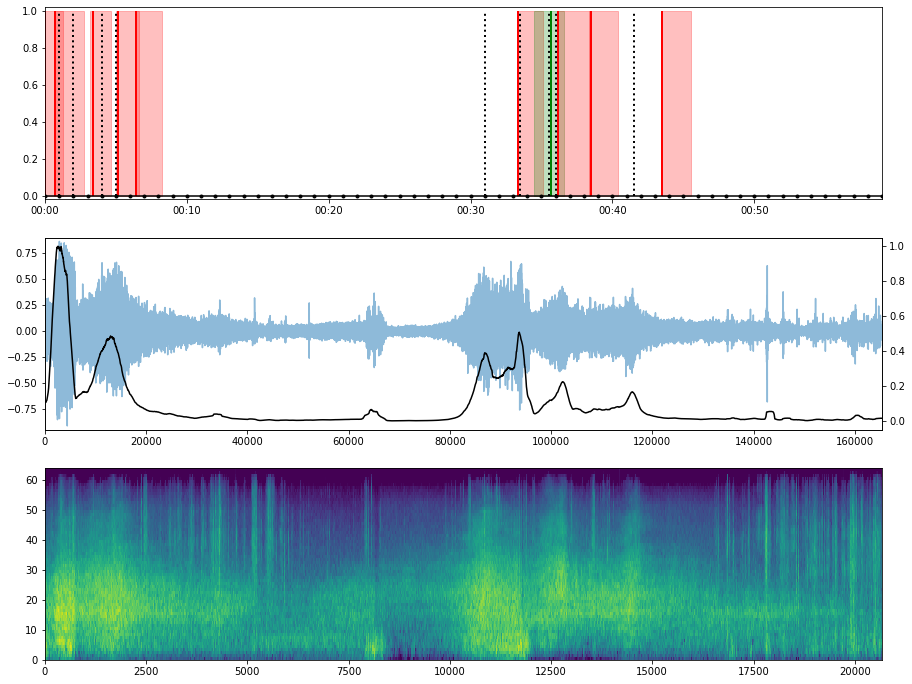

In [5]:
show(
    params,
    signal=signal,
    events=events, 
    events_start_time=events_start_time,
    events_end_time=events_end_time,
    manual_events=manual_events,
    views=views,
    from_time=0 * 60,
    till_time=1 * 60,
    save=False
)

02:00 - 04:00


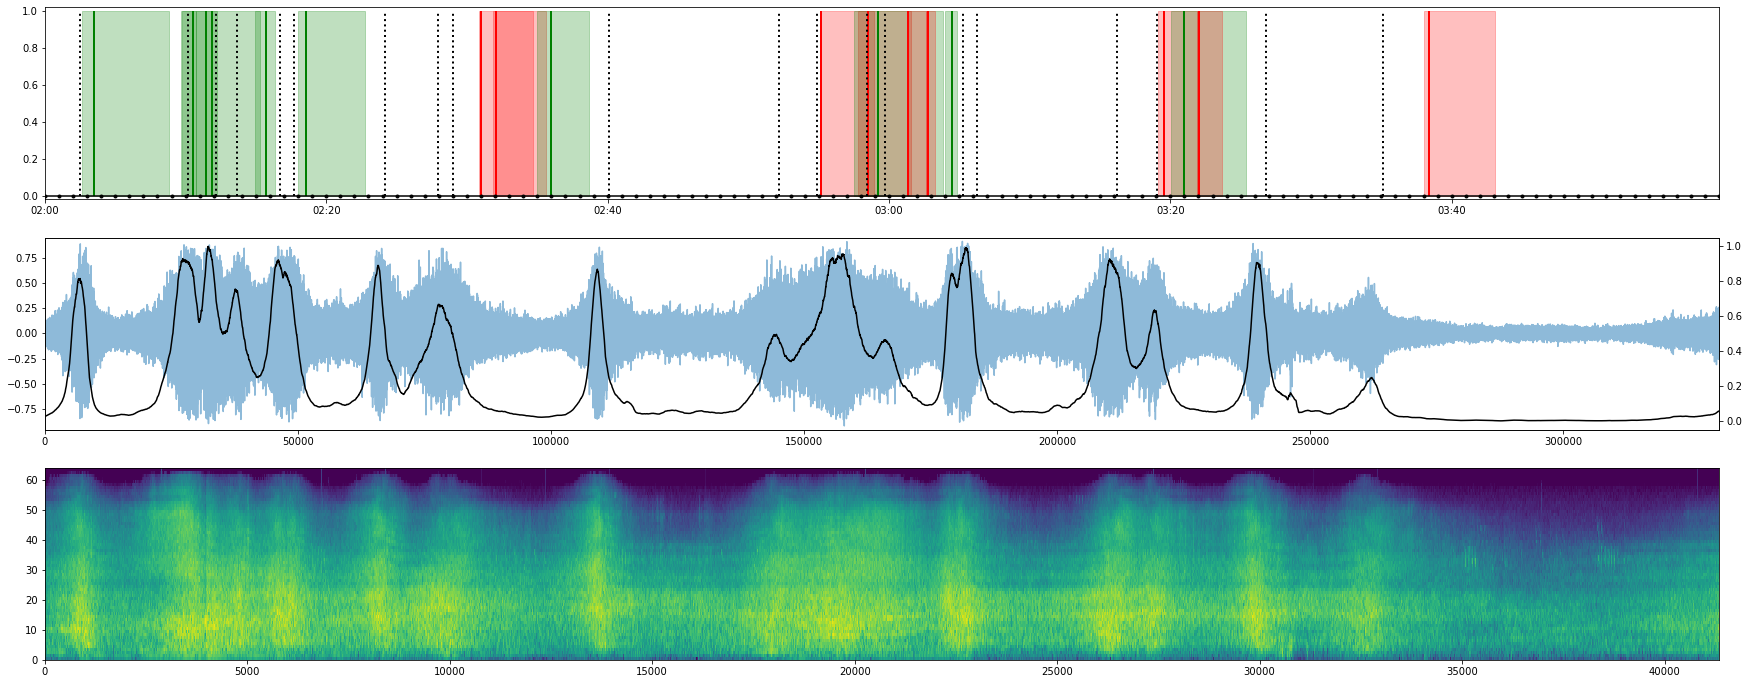

In [27]:
show(
    params,
    signal=signal,
    events=events, 
    events_start_time=events_start_time,
    events_end_time=events_end_time,
    manual_events=manual_events,
    views=views,
    from_time=2 * 60,
    till_time=4 * 60,
)

HTML(f"""
<video width="{1920 * 0.3}" height="{1080 * 0.3}" controls>
    <source src="data/video/{file}.MP4" type="video/mp4">
</video>
""")

In [20]:
s = signal[2 * 60 * params.sr: 3 * 60 * params.sr]
s = torch.stft(s, n_fft=params.n_fft, hop_length=params.hop_length)

In [21]:
energy = s[..., 0].pow(2)
energy = energy.sum(0)

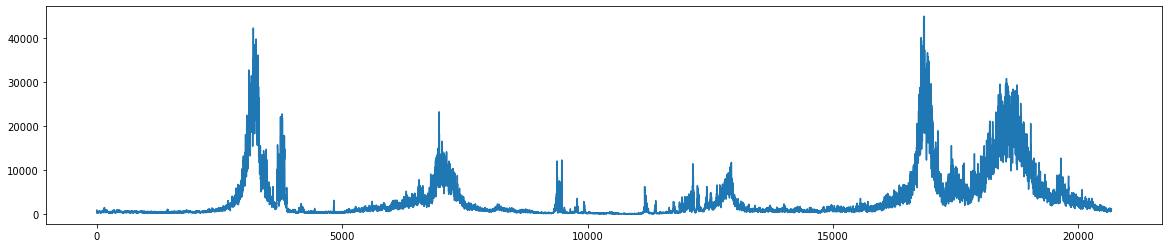

In [22]:
plt.figure(figsize=(20, 4))
plt.plot(energy)